In [ ]:
#|default_exp mixup

# Resnet18d curriculum

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [ ]:
# speed mods
from miniai.utils import *

MetricsCB = LazyMetricsCB
ProgressCB = LazyProgressCB

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=8, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tds.cached = cache_dataset_as_dict(tds)

In [ ]:
from torchvision import transforms

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

## curriculum learning


In [ ]:
def replace_top_losess(n, top_losses, prev_idx):
    num_samples = len(prev_idx)
    top_losses = top_losses.cpu()
    prev_idx = prev_idx.cpu()
    easiest_idx = prev_idx[top_losses[-n:]] 
    hardest_idx = prev_idx[top_losses[:n]]
    indices = torch.arange(num_samples)
    indices[easiest_idx] = hardest_idx
    return indices

top_losses = torch.arange(7)
prev_idx = torch.arange(7).flip(-1)
print(top_losses)
print(prev_idx)
replace_top_losess(3, top_losses, prev_idx)

tensor([0, 1, 2, 3, 4, 5, 6])
tensor([6, 5, 4, 3, 2, 1, 0])


tensor([4, 5, 6, 3, 4, 5, 6])

In [ ]:
from typing import Iterator
from torch.utils.data import DataLoader, WeightedRandomSampler

class TopLossesCallback(Callback):
    def __init__(self):
        self.epoch_preds = []
        self.epoch_targets = []
        
    def before_fit(self, learn):
        self.epoch_preds = []
        self.epoch_targets = []

    @torch.no_grad()
    def _calculate_top_losses(self):
        preds = torch.cat(self.epoch_preds, dim=0)
        targets = torch.cat(self.epoch_targets, dim=0)
        losses = F.cross_entropy(preds, targets, reduce=False)
        return torch.topk(losses, preds.shape[0]).indices
    
    def after_batch(self, learn):
        if learn.training: 
            self.epoch_preds.append(learn.preds)
            self.epoch_targets.append(learn.batch[1])
            
    def before_epoch(self,learn):
        learn.dls.train.sampler.epoch = learn.epoch
        #print("setting epoch", learn.epoch)
        
    def after_epoch(self, learn):
        if self.epoch_preds:
            #print("after epoch", len(self.epoch_targets))
            learn.dls.train.sampler.top_losses = self._calculate_top_losses()
            self.epoch_preds = []
            self.epoch_targets = []
        
# tweaked from tommyc's version
# Before certain epoch drop a % of the training dataset with the lowest losses.
# Replace them with the the same % of the training dataset with the highest losses.
# This gives the model two opportunities to train on the most challenging images.
class CustomTrainingSampler(WeightedRandomSampler):
    def __init__(self, *args, **kwargs):
        WeightedRandomSampler.__init__(self, *args, **kwargs)
        self.data_indexes_for_epoch = torch.randperm(self.num_samples, generator=self.generator)
        self.top_losses = self.data_indexes_for_epoch.clone()
        self.epoch = 0
        self.n = {
            0: 0,
            1: 0.21,
            2: 0.42,
            3: 0.21,
            4: 0
        }

    def setup_epoch(self, epoch=None):
        rand_tensor = torch.randperm(self.num_samples, generator=self.generator)
        n = int(self.n[epoch or self.epoch] * self.num_samples)
        if n != 0:
            new_idx = replace_top_losess(n, self.top_losses, self.data_indexes_for_epoch)
            self.data_indexes_for_epoch = new_idx[rand_tensor]
        else:
            self.data_indexes_for_epoch = rand_tensor

            
    def __iter__(self) -> Iterator[int]:
        self.setup_epoch(self.epoch)
        yield from self.data_indexes_for_epoch

class CustomDataLoader:
    def __init__(self, *dls): 
        self.train,self.valid = dls[:2]

    def get_sampler(num_samples, mode="train"):
        if mode != "train": return None
        return CustomTrainingSampler(weights=[1.0]*num_samples, num_samples=num_samples)

    @classmethod
    def from_dd(cls, dd, batch_size, **kwargs):
        return cls(*[DataLoader(ds, batch_size, sampler=cls.get_sampler(len(ds), mode), collate_fn=collate_dict(ds), **kwargs) 
                     for mode, ds in dd.items()])
    
# lets test that sampler is working
s = CustomTrainingSampler([1]*5, num_samples=5)
s.epoch=1
list(s), s.data_indexes_for_epoch

([tensor(4), tensor(4), tensor(0), tensor(1), tensor(2)],
 tensor([4, 4, 0, 1, 2]))

# run

In [ ]:
dls = DataLoaders.from_dd(tds.cached, bs, num_workers=0)

# tweaked from rohitgeo's version
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics] 
#0.0003 from https://github.com/digantamisra9

In [ ]:
def upscale_cb(scale, mode='bilinear'): 
    return BatchTransformCB(lambda b: (F.interpolate(b[0], scale_factor=scale, mode=mode),b[1]),
                            on_val=True, on_train=True)

In [ ]:
import timm

In [ ]:
rng = rng_seed

In [ ]:
def run(model, leaky=0.0003, m=1, cbs=tuple(), fit=True, train_cb=TrainCB(), epochs=5, base_lr=2e-2, 
        loss_func=F.cross_entropy, bs=bs, tta=False, dls=None, verbose=True, opt_func=optim.AdamW):
    iw = partial(init_weights, leaky=leaky) if leaky is not None else fc.noop
    lr = base_lr*m
    print("Batch size", bs*m)
    dls = dls or DataLoaders.from_dd(tds, bs*m, num_workers=0) 
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
    
    cbs = [DeviceCB(), rng_seed, metrics, BatchSchedCB(sched), *cbs, train_cb] 
    learn = Learner(model.apply(iw), dls, loss_func, lr=lr, cbs=cbs, opt_func=opt_func)
    if verbose: 
        print(torch.randn([3]))
        print(next(iter(learn.dls.train))[1])
    if fit:
        learn.fit(epochs, cbs=[TimeItCB(), ProgressCB(plot=True)])
    if tta:
        ## TTA
        ap1, at = learn.capture_preds()
        ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
        ap2, at = learn.capture_preds(cbs=[ttacb])
        ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
        if verbose: print('TTA:', round((ap==at).float().mean().item(), 4))
    
    return learn

Batch size 256
tensor([ 0.50211972,  1.31441176, -0.10841224])
tensor([7, 8, 1, 6, 3, 8, 7, 7, 6, 6, 8, 2, 5, 0, 4, 2, 9, 6, 9, 5, 2, 7, 6, 8, 9, 7, 7, 9, 5, 1, 9, 2, 0, 4, 8, 4, 3, 2, 7, 8, 7, 9, 7, 2,
        6, 8, 5, 2, 2, 8, 3, 5, 2, 5, 5, 7, 9, 6, 4, 9, 9, 6, 9, 0, 8, 7, 4, 3, 0, 9, 6, 5, 3, 1, 0, 6, 5, 1, 1, 0, 8, 9, 8, 2, 0, 3, 3, 9,
        5, 3, 4, 9, 0, 0, 9, 5, 7, 4, 8, 8, 7, 6, 0, 0, 2, 4, 5, 0, 9, 8, 1, 3, 0, 8, 0, 4, 5, 3, 8, 3, 5, 7, 1, 1, 6, 5, 6, 2, 3, 8, 3, 7,
        1, 3, 7, 0, 0, 9, 8, 9, 3, 6, 5, 5, 5, 0, 8, 6, 9, 4, 6, 5, 6, 2, 5, 7, 1, 8, 9, 2, 8, 3, 8, 6, 9, 9, 4, 2, 8, 5, 3, 6, 8, 7, 3, 1,
        2, 5, 2, 2, 6, 8, 7, 2, 7, 8, 4, 4, 5, 3, 0, 0, 9, 4, 5, 5, 5, 7, 2, 9, 6, 0, 6, 6, 9, 2, 3, 6, 0, 6, 2, 6, 1, 8, 7, 5, 8, 2, 6, 2,
        3, 3, 2, 8, 7, 5, 7, 8, 7, 8, 6, 0, 1, 3, 1, 4, 5, 4, 3, 3, 8, 5, 4, 9, 9, 4, 0, 5, 9, 6, 6, 5, 7, 4, 6, 0])
Using seed 205811062


accuracy,loss,epoch,train
0.806,0.579,0,train
0.620,2.444,0,eval
0.896,0.290,1,train
0.891,0.318,1,eval
0.920,0.222,2,train
0.880,0.390,2,eval
0.940,0.165,3,train
0.930,0.192,3,eval
0.958,0.118,4,train
0.937,0.179,4,eval


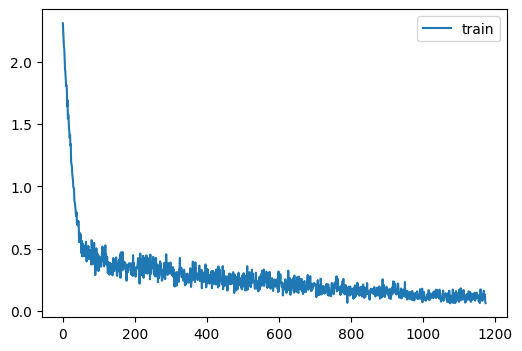

Fit 5 in: 274.65s, setup: 0.00s, 51.93 ± 0.65s per epoch, 0.11 ± 0.01s per batch
Using seed 205811062
Using seed 205811062
TTA: 0.9392


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=5,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], 
            tta=True)

Batch size 256
tensor([0.30707011, 1.60285020, 0.58453292])
tensor([1, 9, 5, 3, 3, 3, 0, 0, 9, 7, 2, 5, 7, 1, 1, 5, 4, 5, 5, 1, 3, 5, 1, 7, 0, 1, 7, 8, 8, 0, 7, 9, 2, 3, 1, 2, 6, 4, 0, 4, 8, 3, 7, 1,
        0, 1, 1, 2, 3, 2, 1, 6, 7, 9, 4, 1, 1, 7, 5, 9, 7, 3, 7, 9, 0, 0, 9, 0, 5, 9, 8, 5, 0, 3, 0, 5, 5, 1, 8, 5, 3, 2, 1, 1, 9, 0, 2, 0,
        5, 8, 0, 3, 3, 8, 3, 4, 7, 3, 6, 2, 5, 9, 5, 8, 6, 0, 4, 7, 3, 5, 7, 2, 5, 7, 8, 8, 1, 8, 6, 0, 6, 6, 9, 4, 5, 9, 2, 8, 8, 6, 8, 7,
        3, 0, 3, 7, 7, 3, 3, 8, 7, 7, 6, 5, 8, 7, 9, 8, 0, 9, 0, 7, 8, 2, 7, 5, 3, 3, 2, 6, 3, 7, 4, 2, 3, 9, 3, 8, 9, 1, 3, 8, 9, 5, 6, 2,
        2, 1, 3, 2, 4, 4, 5, 1, 3, 1, 4, 5, 8, 0, 1, 9, 2, 1, 8, 3, 9, 9, 2, 6, 2, 4, 4, 6, 8, 2, 4, 5, 4, 4, 8, 2, 2, 3, 7, 4, 5, 9, 6, 4,
        2, 5, 6, 6, 7, 7, 9, 7, 9, 4, 8, 2, 8, 9, 3, 2, 6, 5, 7, 5, 6, 2, 0, 0, 5, 6, 8, 6, 2, 9, 3, 6, 4, 9, 2, 6])
Using seed 205811062


accuracy,loss,epoch,train
0.807,0.582,0,train
0.803,0.565,0,eval
0.841,0.425,1,train
0.866,0.378,1,eval
0.842,0.412,2,train
0.905,0.260,2,eval
0.900,0.255,3,train
0.930,0.206,3,eval
0.980,0.055,4,train
0.939,0.194,4,eval


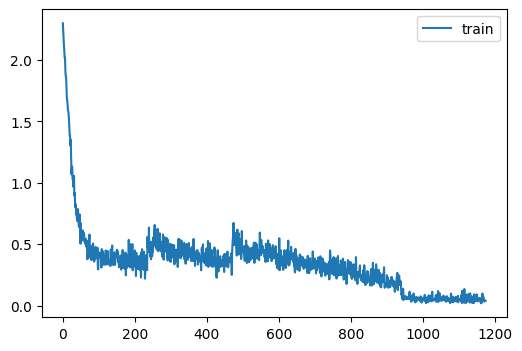

Fit 5 in: 214.93s, setup: 0.00s, 41.75 ± 0.51s per epoch, 0.11 ± 0.01s per batch
Using seed 205811062
Using seed 205811062
TTA: 0.9428


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=5,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb, TopLossesCallback()], 
            dls = CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            tta=True)


Batch size 256
tensor([0.30707011, 1.60285020, 0.58453292])
tensor([1, 9, 5, 3, 3, 3, 0, 0, 9, 7, 2, 5, 7, 1, 1, 5, 4, 5, 5, 1, 3, 5, 1, 7, 0, 1, 7, 8, 8, 0, 7, 9, 2, 3, 1, 2, 6, 4, 0, 4, 8, 3, 7, 1,
        0, 1, 1, 2, 3, 2, 1, 6, 7, 9, 4, 1, 1, 7, 5, 9, 7, 3, 7, 9, 0, 0, 9, 0, 5, 9, 8, 5, 0, 3, 0, 5, 5, 1, 8, 5, 3, 2, 1, 1, 9, 0, 2, 0,
        5, 8, 0, 3, 3, 8, 3, 4, 7, 3, 6, 2, 5, 9, 5, 8, 6, 0, 4, 7, 3, 5, 7, 2, 5, 7, 8, 8, 1, 8, 6, 0, 6, 6, 9, 4, 5, 9, 2, 8, 8, 6, 8, 7,
        3, 0, 3, 7, 7, 3, 3, 8, 7, 7, 6, 5, 8, 7, 9, 8, 0, 9, 0, 7, 8, 2, 7, 5, 3, 3, 2, 6, 3, 7, 4, 2, 3, 9, 3, 8, 9, 1, 3, 8, 9, 5, 6, 2,
        2, 1, 3, 2, 4, 4, 5, 1, 3, 1, 4, 5, 8, 0, 1, 9, 2, 1, 8, 3, 9, 9, 2, 6, 2, 4, 4, 6, 8, 2, 4, 5, 4, 4, 8, 2, 2, 3, 7, 4, 5, 9, 6, 4,
        2, 5, 6, 6, 7, 7, 9, 7, 9, 4, 8, 2, 8, 9, 3, 2, 6, 5, 7, 5, 6, 2, 0, 0, 5, 6, 8, 6, 2, 9, 3, 6, 4, 9, 2, 6])
Using seed 205811062


accuracy,loss,epoch,train
0.819,0.555,0,train
0.787,0.699,0,eval
0.849,0.399,1,train
0.909,0.247,1,eval
0.863,0.353,2,train
0.917,0.231,2,eval
0.945,0.148,3,train
0.935,0.228,3,eval
0.996,0.013,4,train
0.942,0.237,4,eval


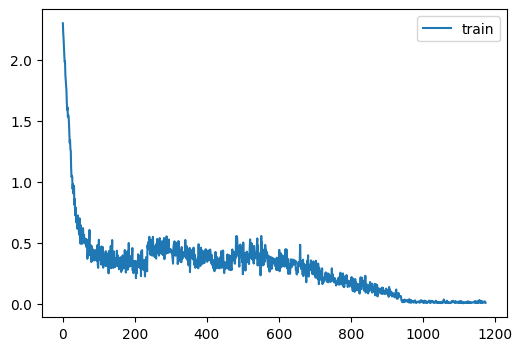

Fit 5 in: 215.06s, setup: 0.00s, 41.77 ± 0.33s per epoch, 0.11 ± 0.00s per batch
Using seed 205811062
Using seed 205811062
TTA: 0.9296


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=5,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), TopLossesCallback()], 
            dls = CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            tta=True)


In [ ]:
def mixup_data_per_batch(x, y, sampler=torch.distributions.Beta(tensor(1), tensor(1)).sample):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    lam = sampler([1]).to(x.device)
    batch_size = x.shape[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, (y_a, y_b, lam, index)

def mixup_data_prev(x, y, sampler):
    r = mixup_data((x,y), None, sampler=sampler)
    return r.mixed_x, (r.y1.float(), r.y2.float(), r.lam, r.index)

def mixup_criterion_per_batch(pred, my, lf=F.cross_entropy, **_):
    y_a, y_b, lam, *_ = my
    return lam * lf(pred, y_a) + (1 - lam) * lf(pred, y_b)

class MixUpCB(TrainCB):
    def __init__(self,alpha=0.4, mix_data=mixup_data_per_batch, mix_loss=mixup_criterion_per_batch, label_smoothing=None,**kw): 
        super().__init__(**kw)
        self.alpha = alpha
        self.dist = torch.distributions.Beta(self.alpha,self.alpha)
        self.mix_data = mix_data
        self.loss_func = mix_loss
        self.label_smoothing = label_smoothing
        
    def before_fit(self, learn):
        self.base_lf = learn.loss_func
        
    def sample(self, shape): return self.dist.sample([1])
    
    def before_batch(self, learn):
        if learn.training and self.alpha is not None: 
            bx, mixup = self.mix_data(*learn.batch, self.sample)
            learn.batch = bx, learn.batch[1]
            learn.mixup = mixup

    def get_loss(self, learn):
        if learn.training and self.alpha is not None:
            learn.loss = self.loss_func(learn.preds, learn.mixup, label_smoothing=self.label_smoothing) # todo  *learn.batch[self.n_inp:]   
        else:
            super().get_loss(learn)

Batch size 256
tensor([0.30707011, 1.60285020, 0.58453292])
tensor([1, 9, 5, 3, 3, 3, 0, 0, 9, 7, 2, 5, 7, 1, 1, 5, 4, 5, 5, 1, 3, 5, 1, 7, 0, 1, 7, 8, 8, 0, 7, 9, 2, 3, 1, 2, 6, 4, 0, 4, 8, 3, 7, 1,
        0, 1, 1, 2, 3, 2, 1, 6, 7, 9, 4, 1, 1, 7, 5, 9, 7, 3, 7, 9, 0, 0, 9, 0, 5, 9, 8, 5, 0, 3, 0, 5, 5, 1, 8, 5, 3, 2, 1, 1, 9, 0, 2, 0,
        5, 8, 0, 3, 3, 8, 3, 4, 7, 3, 6, 2, 5, 9, 5, 8, 6, 0, 4, 7, 3, 5, 7, 2, 5, 7, 8, 8, 1, 8, 6, 0, 6, 6, 9, 4, 5, 9, 2, 8, 8, 6, 8, 7,
        3, 0, 3, 7, 7, 3, 3, 8, 7, 7, 6, 5, 8, 7, 9, 8, 0, 9, 0, 7, 8, 2, 7, 5, 3, 3, 2, 6, 3, 7, 4, 2, 3, 9, 3, 8, 9, 1, 3, 8, 9, 5, 6, 2,
        2, 1, 3, 2, 4, 4, 5, 1, 3, 1, 4, 5, 8, 0, 1, 9, 2, 1, 8, 3, 9, 9, 2, 6, 2, 4, 4, 6, 8, 2, 4, 5, 4, 4, 8, 2, 2, 3, 7, 4, 5, 9, 6, 4,
        2, 5, 6, 6, 7, 7, 9, 7, 9, 4, 8, 2, 8, 9, 3, 2, 6, 5, 7, 5, 6, 2, 0, 0, 5, 6, 8, 6, 2, 9, 3, 6, 4, 9, 2, 6])
Using seed 205811062


accuracy,loss,epoch,train
0.454,1.022,0,train
0.770,0.702,0,eval
0.474,0.760,1,train
0.845,0.491,1,eval
0.474,0.673,2,train
0.919,0.258,2,eval
0.524,0.579,3,train
0.938,0.205,3,eval
0.477,0.476,4,train
0.943,0.181,4,eval


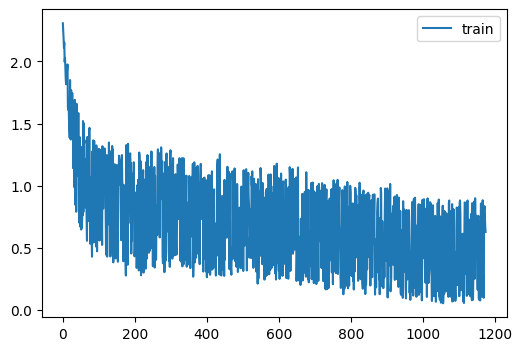

/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/piotr/miniconda3/envs/miniai/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Fit 5 in: 139.88s, setup: 0.00s, 26.62 ± 0.05s per epoch, 0.11 ± 0.01s per batch
Using seed 205811062
Using seed 205811062
TTA: 0.8792


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=5,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), TopLossesCallback()], 
            train_cb=MixUpCB(0.4),
            dls = CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            tta=True)


## TODO:
- mixup curriculum
- remove weight decay
- try_alternative adam

Batch size 256
tensor([0.30707011, 1.60285020, 0.58453292])
tensor([1, 9, 5, 3, 3, 3, 0, 0, 9, 7, 2, 5, 7, 1, 1, 5, 4, 5, 5, 1, 3, 5, 1, 7, 0, 1, 7, 8, 8, 0, 7, 9, 2, 3, 1, 2, 6, 4, 0, 4, 8, 3, 7, 1,
        0, 1, 1, 2, 3, 2, 1, 6, 7, 9, 4, 1, 1, 7, 5, 9, 7, 3, 7, 9, 0, 0, 9, 0, 5, 9, 8, 5, 0, 3, 0, 5, 5, 1, 8, 5, 3, 2, 1, 1, 9, 0, 2, 0,
        5, 8, 0, 3, 3, 8, 3, 4, 7, 3, 6, 2, 5, 9, 5, 8, 6, 0, 4, 7, 3, 5, 7, 2, 5, 7, 8, 8, 1, 8, 6, 0, 6, 6, 9, 4, 5, 9, 2, 8, 8, 6, 8, 7,
        3, 0, 3, 7, 7, 3, 3, 8, 7, 7, 6, 5, 8, 7, 9, 8, 0, 9, 0, 7, 8, 2, 7, 5, 3, 3, 2, 6, 3, 7, 4, 2, 3, 9, 3, 8, 9, 1, 3, 8, 9, 5, 6, 2,
        2, 1, 3, 2, 4, 4, 5, 1, 3, 1, 4, 5, 8, 0, 1, 9, 2, 1, 8, 3, 9, 9, 2, 6, 2, 4, 4, 6, 8, 2, 4, 5, 4, 4, 8, 2, 2, 3, 7, 4, 5, 9, 6, 4,
        2, 5, 6, 6, 7, 7, 9, 7, 9, 4, 8, 2, 8, 9, 3, 2, 6, 5, 7, 5, 6, 2, 0, 0, 5, 6, 8, 6, 2, 9, 3, 6, 4, 9, 2, 6])
Using seed 205811062


accuracy,loss,epoch,train
0.454,1.021,0,train
0.762,0.712,0,eval
0.476,0.757,1,train
0.768,0.737,1,eval
0.473,0.671,2,train
0.921,0.246,2,eval
0.523,0.572,3,train
0.939,0.189,3,eval
0.477,0.474,4,train
0.944,0.179,4,eval


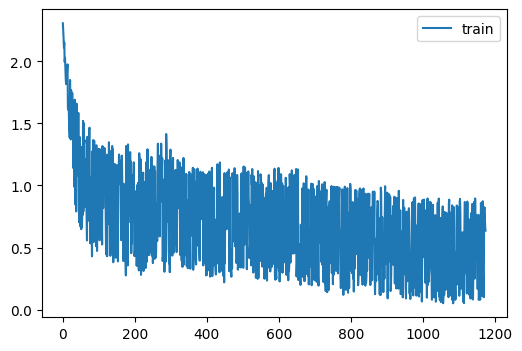

Fit 5 in: 140.94s, setup: 0.00s, 26.85 ± 0.42s per epoch, 0.11 ± 0.01s per batch
Using seed 205811062
Using seed 205811062
TTA: 0.8757


In [ ]:
rng.previous()
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=5,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), TopLossesCallback()], 
            train_cb=MixUpCB(0.4),
            dls = CustomDataLoader.from_dd(tds.cached, bs, num_workers=0),
            tta=True, opt_func=partial(optim.AdamW,weight_decay=0.0))